# **SETUP**

In [3]:
import numpy as np
import tensorflow as tf
import PIL
import PIL.Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [27]:
print(tf.__version__)

2.12.0


In [6]:
# Load data
import pathlib
lokasi = r"C:\Users\jonat\Downloads\Bangkit 2023 Capstone\WasteDataset"
data_dir = pathlib.Path(lokasi).with_suffix('')

# **Data Preprocesing**

**Total semua data**

In [9]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

11405


**Parameter**

In [8]:
# batch_size = 32
img_height = 256
img_width = 256

**Augmentasi**

In [13]:
def aug(data,validasi):
    # Inisialisasi datagen validasi
    train_datagen = ImageDataGenerator(rescale=1.0/255.)

    # Load data training
    train_generator = train_datagen.flow_from_directory(directory=data,
                                                        batch_size=32,
                                                        class_mode='sparse',
                                                        target_size=(img_height, img_width))

    # Inisialisasi datagen validasi
    validation_datagen = ImageDataGenerator(rescale = 1./255)

    # Load data validasi
    validation_generator = validation_datagen.flow_from_directory(directory=validasi,
                                                                batch_size=32,
                                                                class_mode='sparse',
                                                                target_size=(img_height, img_width))
    
    return train_generator, validation_generator

In [14]:
# Menentukan lokasi dataset training dan validasi
train_generator, validation_generator = aug(r'C:\Users\jonat\Downloads\Bangkit 2023 Capstone\classification_data_3\train', r'C:\Users\jonat\Downloads\Bangkit 2023 Capstone\classification_data_3\val')

Found 9121 images belonging to 6 classes.


Found 2284 images belonging to 6 classes.


**Info Batch**

In [15]:
# banyaknya batch dan bentuk data dalam validasi
for batch_gambar, batch_kelas in validation_generator:
    print(batch_gambar.shape)
    print(batch_kelas.shape)
    break

(32, 256, 256, 3)
(32,)


In [33]:
#banyaknya kelas dan nama kelas
nama_kelas = validation_generator.class_indices
banyak_kelas = len(nama_kelas)
print(banyak_kelas)
print(nama_kelas)

6
{'AluCan': 0, 'Cardboard': 1, 'Detergent': 2, 'Glass': 3, 'HDPEM': 4, 'PET': 5}


# **Model**

**Buat model**

In [16]:
def create_model():

  model = tf.keras.models.Sequential([
    # Layer Normalisasi
    # tf.keras.layers.Rescaling(1/255.),
    # Convo Pertama
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # tf.keras.layers.Dropout(0.5),
    
    # Convo Kedua
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.Dropout(0.2),

    # Convo layer ketiga
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
  
    tf.keras.layers.Dense(6, activation='softmax')
])

  model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model 

**Train dan validate model**

In [19]:
# Save model
model = create_model()

# Train model
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=15,
                    steps_per_epoch=100,
                    validation_steps=50)

Epoch 1/15
100/100 [==============================] - 128s 1s/step - loss: 1.7185 - accuracy: 0.3847 - val_loss: 2.1623 - val_accuracy: 0.3300
Epoch 2/15
100/100 [==============================] - 122s 1s/step - loss: 1.2242 - accuracy: 0.5112 - val_loss: 1.3445 - val_accuracy: 0.4219
Epoch 3/15
100/100 [==============================] - 120s 1s/step - loss: 1.0560 - accuracy: 0.5834 - val_loss: 1.0082 - val_accuracy: 0.5975
Epoch 4/15
100/100 [==============================] - 118s 1s/step - loss: 0.9605 - accuracy: 0.6273 - val_loss: 0.9899 - val_accuracy: 0.6212
Epoch 5/15
100/100 [==============================] - 117s 1s/step - loss: 0.8564 - accuracy: 0.6854 - val_loss: 1.0444 - val_accuracy: 0.6100
Epoch 6/15
100/100 [==============================] - 116s 1s/step - loss: 0.7343 - accuracy: 0.7259 - val_loss: 0.8577 - val_accuracy: 0.6875
Epoch 7/15
100/100 [==============================] - 115s 1s/step - loss: 0.6712 - accuracy: 0.7554 - val_loss: 0.7957 - val_accuracy: 0.7163

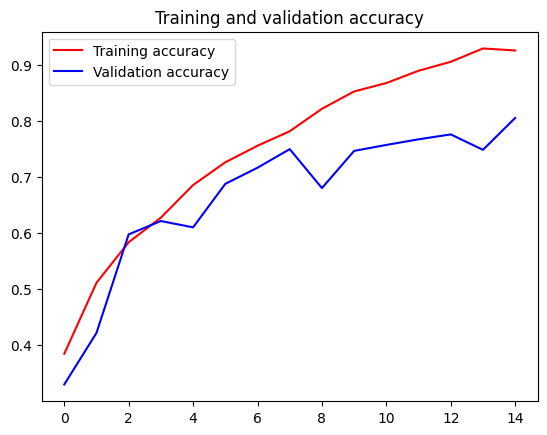

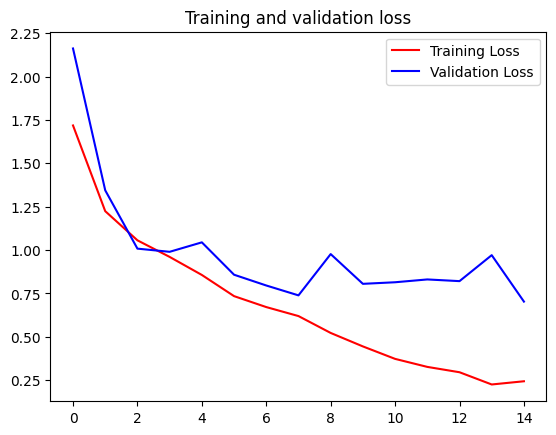

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **Save Model**

**TF Lite**

In [21]:
export_dir = './model_1_1'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: ./model_1_1\assets


INFO:tensorflow:Assets written to: ./model_1_1\assets


In [23]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [24]:
tflite_model_file = pathlib.Path('carupah_model_2.tflite')
tflite_model_file.write_bytes(tflite_model)

29527064

**JS**

In [25]:
import time

saved_model_path = "carupah_model_2.h5".format(int(time.time()))

model.save(saved_model_path)

**JS Converter**

In [31]:
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

**Saved Python Object**

In [ ]:
import pickle
pickle.dump(nama_kelas, open('data_classes.pkl','wb'))